In [ ]:
!pip install pyscipopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 32.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
from pyscipopt import Model, quicksum
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import binary_dilation

In [ ]:
#PARAMETRY
n = 100
KRATKA_M = 20  # 1 kratka = 20 m

D_MIN_M = 50
bufor_m = 700
droga_szer_m = 5

d_min = int(np.ceil(D_MIN_M / KRATKA_M))  # 3 kratki
bufor = max(1, round(bufor_m / KRATKA_M))  # 700m = 35 kratek
droga_szer = max(1, round(droga_szer_m / KRATKA_M))  # 5m = 1 kratka

#SIATKA
siatka = np.zeros((n, n))

def dodaj_prostokat(sr, sc, wys, szer, kod=1):
    r_start = max(0, sr - wys // 2)
    r_end = min(n, sr + (wys + 1) // 2)
    c_start = max(0, sc - szer // 2)
    c_end = min(n, sc + (szer + 1) // 2)
    siatka[r_start:r_end, c_start:c_end] = kod

#DROGA
for i in range(n):
    dodaj_prostokat(i, n // 2, 1, droga_szer, kod=2)

#BUDYNKI
budynki_m = [
    ((300, 850), (120, 180)),
    ((1600, 800), (100, 100)),
    ((1500, 1200), (80, 120)),
    ((1200, 1200), (90, 90)),
    ((200, 1200), (100,120)),
    ((600, 800), (120, 80)),
    ((800, 800), (100, 120)),
    ((600, 1200), (120, 80)),
    ((800, 1200), (100, 120)),

]
for (sr_m, sc_m), (wys_m, szer_m) in budynki_m:
    sr = sr_m // KRATKA_M
    sc = sc_m // KRATKA_M
    wys = max(1, wys_m // KRATKA_M)
    szer = max(1, szer_m // KRATKA_M)

    dodaj_prostokat(sr, sc, wys, szer, kod=1)

#MASKA BUFROWA
przeszkody = (siatka != 0)
bufor_mask = binary_dilation(przeszkody, iterations=bufor)

#POLA DOZWOLONE TAK ZWANE
puste_pola = [(i, j) for i in range(n) for j in range(n) if not bufor_mask[i, j]]


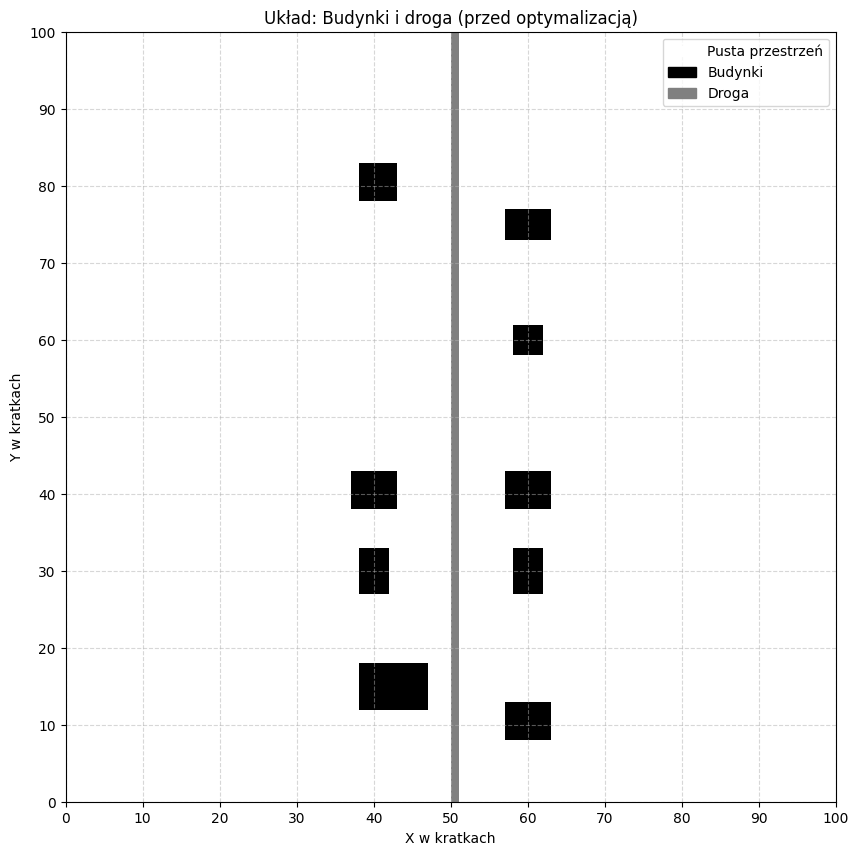

In [ ]:
kolory = {0: "white", 1: "black", 2: "gray"}
cmap = plt.matplotlib.colors.ListedColormap([kolory[i] for i in sorted(kolory.keys())])

plt.figure(figsize=(10, 10))
plt.imshow(siatka, cmap=cmap, origin='lower', extent=[0, n, 0, n])
plt.title("Układ: Budynki i droga (przed optymalizacją)")
legend_labels = [
    mpatches.Patch(color="white", label="Pusta przestrzeń"),
    mpatches.Patch(color="black", label="Budynki"),
    mpatches.Patch(color="gray", label="Droga")
]
plt.legend(handles=legend_labels, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(np.arange(0, n + 1,10))
plt.yticks(np.arange(0, n + 1,10))
plt.xlabel("X w kratkach")
plt.ylabel("Y w kratkach")
plt.show()

In [ ]:
#MODEL SCIP
model = Model("Rozmieszczenie turbin")
x = {(i, j): model.addVar(vtype="B", name=f"x_{i}_{j}") for (i, j) in puste_pola}

#OGRANICZENIA ODLEGŁOŚCI
zakres = d_min + 1
for (i1, j1) in puste_pola:
    for di in range(-zakres, zakres + 1):
        for dj in range(-zakres, zakres + 1):
            i2, j2 = i1 + di, j1 + dj
            if (di, dj) != (0, 0) and (i2, j2) in x:
                dyst = np.hypot(di, dj) * KRATKA_M
                if dyst < D_MIN_M:
                    model.addCons(x[i1, j1] + x[i2, j2] <= 1)

#FUNKCJA CELU
model.setObjective(quicksum(x[i, j] for (i, j) in x), "maximize")
model.optimize()


In [ ]:
#WYNIKI
turbiny = [(i, j) for (i, j) in x if model.getVal(x[i, j]) > 0.5]
print("Liczba turbin:", len(turbiny))

Liczba turbin: 219


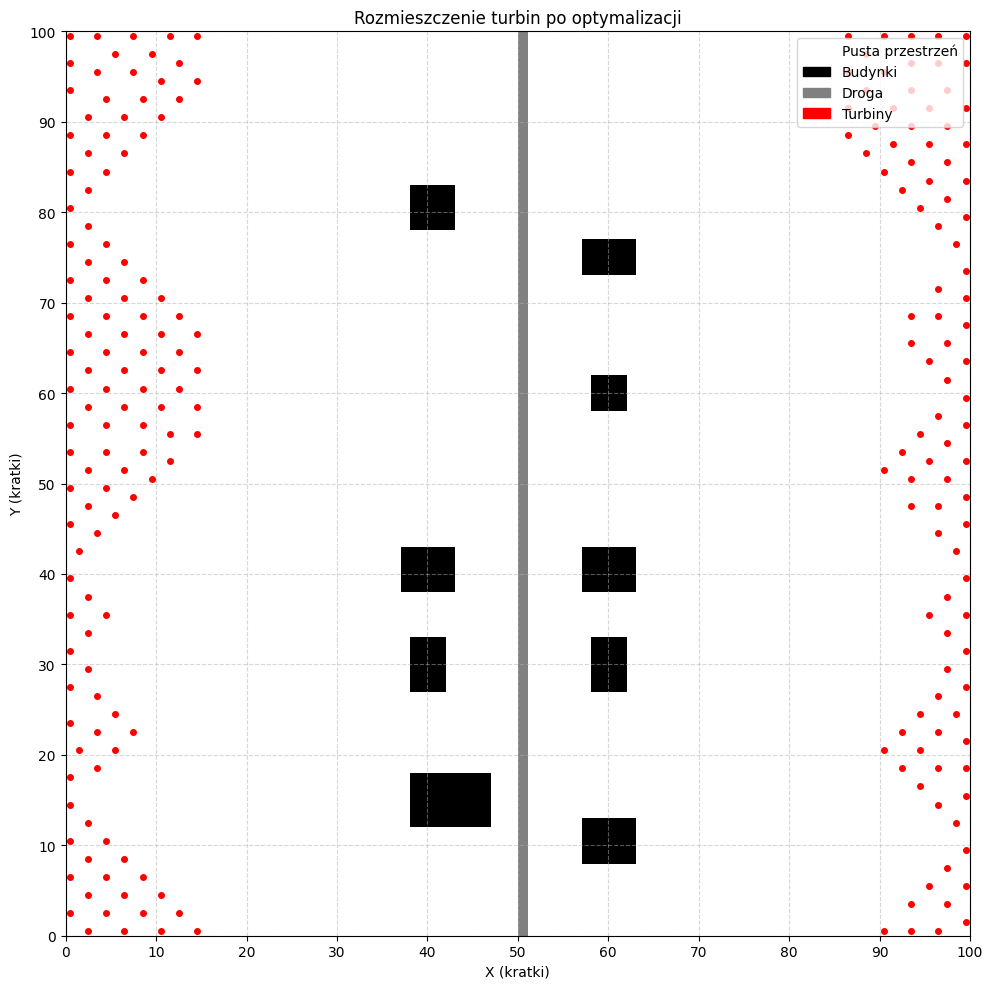

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(siatka, cmap=cmap, origin='lower', extent=[0, n, 0, n])
for i, j in turbiny:
    plt.plot(j + 0.5, i + 0.5, 'ro', markersize=4)

plt.title("Rozmieszczenie turbin po optymalizacji")
legend = [
    mpatches.Patch(color="white", label="Pusta przestrzeń"),
    mpatches.Patch(color="black", label="Budynki"),
    mpatches.Patch(color="gray", label="Droga"),
    mpatches.Patch(color="red", label="Turbiny")
]
plt.legend(handles=legend, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(0, n + 1, 10))
plt.yticks(np.arange(0, n + 1, 10))
plt.xlabel("X (kratki)")
plt.ylabel("Y (kratki)")
plt.tight_layout()
plt.show()